# Import

In [60]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

import json

In [61]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [62]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

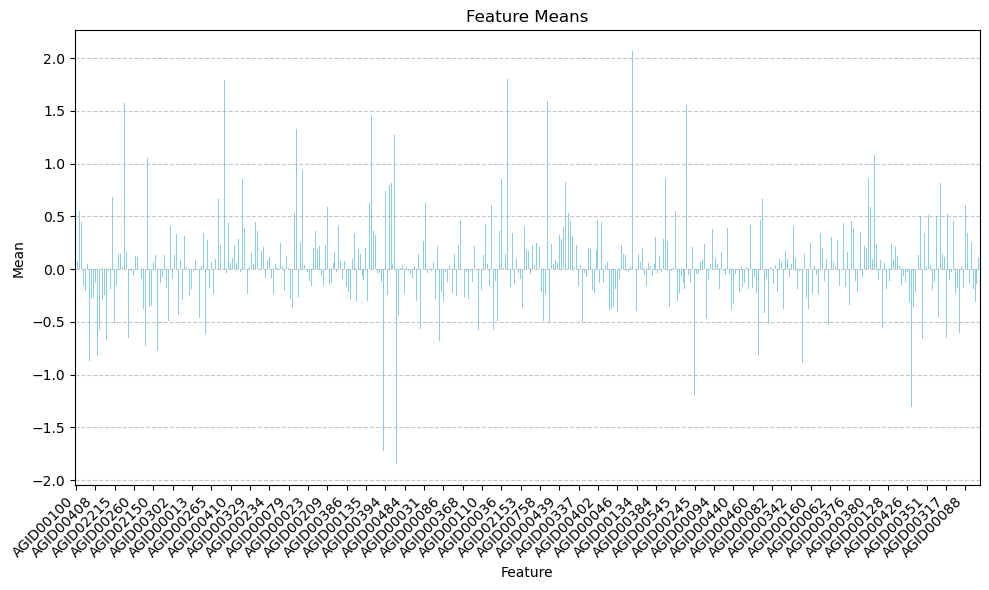

In [63]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [64]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.8,
                                                    random_state=1)

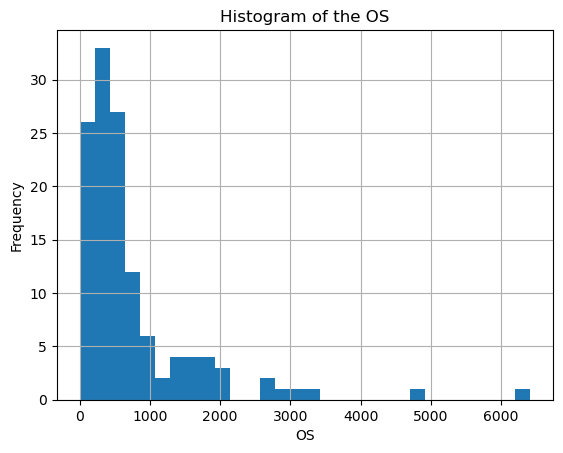

In [65]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

# AE

In [72]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,size,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.size = size
        self.classifer = None
        self.cv_scores = {}
        self.type = type

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=40,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.size)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_{self.size}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.size)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.size)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.size)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=10):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            self.cv_scores[name] = mean_cv_score
            
            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        print(f"Size: {self.size}, Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.size)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        self.classifer = svm_classifier





In [73]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=40,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


In [74]:
class SAE(AE):
    def train(self):

        n_features = len(self.X_train.columns)

        # Define the encoder
        input_layer = Input(shape=(n_features,))
        # Add L1 regularization to encourage sparsity
        encoder = Dense(64, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(input_layer)  # Adjust regularization rate as needed
        encoder = Dense(32, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(encoder)  # Adjust regularization rate as needed

        # Define the bottleneck
        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder = Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        # Callback to save the best model
        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=40,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        self.encode()
        self.map_y()



In [75]:
class DSAE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu',activity_regularizer=regularizers.l1(1e-4))(input_layer)

        encoder = Dense(128, activation='relu',activity_regularizer=regularizers.l1(1e-4))(input_layer)
        encoder = Dense(64, activation='relu',activity_regularizer=regularizers.l1(1e-4))(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=40,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


# Dispatcher

In [76]:
def dispatcher(model,type,min_bottleneck, max_bottleneck,step =4):
    current_size = min_bottleneck
    AEs = []
    results = []
    while current_size <= max_bottleneck:
        name = f"bottleneck_{current_size}"
        AEs.append(model(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = current_size,size = name,type = type))
        current_size += step
    for AE_to_train in AEs:
        AE_to_train.train()
        AE_to_train.cross_validation_model_selection()
        results.append({f"{type} {name}": AE_to_train.cv_scores})
    
    output = json.dumps(results)
    with open(f"output\{type}_model_output.json","w") as file:
        file.write(output)
    return
    

In [77]:
dispatcher(AE,"AE",8,48)

Epoch 1/40
25/26 [===========================>..] - ETA: 0s - loss: 0.0374 
Epoch 1: val_loss improved from inf to 0.02685, saving model to model\AE_bottleneck_8_best_model.keras
26/26 [==============================] - 1s 14ms/step - loss: 0.0373 - val_loss: 0.0269
Epoch 2/40
 1/26 [>.............................] - ETA: 0s - loss: 0.0218
Epoch 2: val_loss improved from 0.02685 to 0.02423, saving model to model\AE_bottleneck_8_best_model.keras
26/26 [==============================] - 0s 4ms/step - loss: 0.0237 - val_loss: 0.0242
Epoch 3/40
24/26 [==========================>...] - ETA: 0s - loss: 0.0225
Epoch 3: val_loss improved from 0.02423 to 0.02370, saving model to model\AE_bottleneck_8_best_model.keras
26/26 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0237
Epoch 4/40
 1/26 [>.............................] - ETA: 0s - loss: 0.0250
Epoch 4: val_loss improved from 0.02370 to 0.02330, saving model to model\AE_bottleneck_8_best_model.keras
26/26 [======

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5524615384615383
SVM - Mean Confusion Matrix:
[[7.9 4.7]
 [6.9 6.4]]
RandomForest - Mean CV Score: 0.5638461538461538
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [5.5 7.8]]
KNN - Mean CV Score: 0.5484615384615383
KNN - Mean Confusion Matrix:
[[7.6 5. ]
 [6.7 6.6]]
GradientBoosting - Mean CV Score: 0.576
GradientBoosting - Mean Confusion Matrix:
[[7.3 5.3]
 [5.7 7.6]]
AdaBoost - Mean CV Score: 0.5984615384615385
AdaBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5444615384615383
NaiveBayes - Mean Confusion Matrix:
[[10.8  1.8]
 [10.   3.3]]
DecisionTree - Mean CV Score: 0.5216923076923077
DecisionTree - Mean Confusion Matrix:
[[6.2 6.4]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6138461538461538
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5446153846153845
XGBoost - Mean Confusion Matrix:
[[6.3 6.3]
 [5.5 7.8]]
Size: bottleneck_16, Best classifier: ExtraTrees, CV Score: 0.61384615384

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5716923076923077
SVM - Mean Confusion Matrix:
[[7.4 5.2]
 [5.9 7.4]]
RandomForest - Mean CV Score: 0.6333846153846154
RandomForest - Mean Confusion Matrix:
[[7.7 4.9]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5907692307692307
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.6026153846153846
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.5869230769230769
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.4864615384615384
NaiveBayes - Mean Confusion Matrix:
[[10.5  2.1]
 [11.2  2.1]]
DecisionTree - Mean CV Score: 0.5524615384615384
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6258461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6298461538461539
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.5 8.8]]
Size: bottleneck_20, Best classifier: RandomForest, CV Score

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5833846153846153
RandomForest - Mean Confusion Matrix:
[[6.5 6.1]
 [4.7 8.6]]
KNN - Mean CV Score: 0.548
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [6.8 6.5]]
GradientBoosting - Mean CV Score: 0.6223076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [5.  8.3]]
AdaBoost - Mean CV Score: 0.5403076923076924
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [6.2 7.1]]
NaiveBayes - Mean CV Score: 0.5169230769230769
NaiveBayes - Mean Confusion Matrix:
[[12.   0.6]
 [11.9  1.4]]
DecisionTree - Mean CV Score: 0.5372307692307693
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5830769230769229
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5758461538461538
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
Size: bottleneck_24, Best classifier: GradientBoosting, CV Score: 0.6223076923076923
Epoch 1/40
 1/26 [>.............................] - ETA: 23s - loss: 0.0539
Epoc

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5950769230769231
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
KNN - Mean CV Score: 0.5563076923076923
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [6.6 6.7]]
GradientBoosting - Mean CV Score: 0.5327692307692307
GradientBoosting - Mean Confusion Matrix:
[[6.4 6.2]
 [5.9 7.4]]
AdaBoost - Mean CV Score: 0.5641538461538461
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5133846153846153
NaiveBayes - Mean Confusion Matrix:
[[9.9 2.7]
 [9.9 3.4]]
DecisionTree - Mean CV Score: 0.5215384615384615
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [6.3 7. ]]
ExtraTrees - Mean CV Score: 0.5949230769230768
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.5750769230769232
XGBoost - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
Size: bottleneck_28, Best classifier: RandomForest, CV Score: 0.5950769230769231
Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0462

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5983076923076922
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [4.7 8.6]]
KNN - Mean CV Score: 0.5861538461538462
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.5401538461538462
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [6.4 6.9]]
AdaBoost - Mean CV Score: 0.5286153846153846
AdaBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.583076923076923
NaiveBayes - Mean Confusion Matrix:
[[7.7 4.9]
 [5.9 7.4]]
DecisionTree - Mean CV Score: 0.5443076923076923
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6138461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.556
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.9 7.4]]
Size: bottleneck_32, Best classifier: ExtraTrees, CV Score: 0.6138461538461539
Epoch 1/40
 1/26 [>.............................] - ETA: 23s - loss: 0.0449
Epoch 1: val_lo

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5869230769230769
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [5.1 8.2]]
RandomForest - Mean CV Score: 0.6407692307692308
RandomForest - Mean Confusion Matrix:
[[7.8 4.8]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6329230769230769
KNN - Mean Confusion Matrix:
[[9.  3.6]
 [5.9 7.4]]
GradientBoosting - Mean CV Score: 0.625076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [4.9 8.4]]
AdaBoost - Mean CV Score: 0.6138461538461538
AdaBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.571076923076923
NaiveBayes - Mean Confusion Matrix:
[[8.9 3.7]
 [7.4 5.9]]
DecisionTree - Mean CV Score: 0.5904615384615385
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [4.5 8.8]]
ExtraTrees - Mean CV Score: 0.6098461538461539
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6218461538461538
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.5 8.8]]
Size: bottleneck_36, Best classifier: RandomForest, CV Score: 0.64

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.6060000000000001
RandomForest - Mean Confusion Matrix:
[[7.  5.6]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5524615384615383
KNN - Mean Confusion Matrix:
[[7.5 5.1]
 [6.5 6.8]]
GradientBoosting - Mean CV Score: 0.5670769230769231
GradientBoosting - Mean Confusion Matrix:
[[6.5 6.1]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.579076923076923
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.566923076923077
NaiveBayes - Mean Confusion Matrix:
[[9.7 2.9]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.5518461538461539
DecisionTree - Mean Confusion Matrix:
[[7.6 5. ]
 [6.6 6.7]]
ExtraTrees - Mean CV Score: 0.5944615384615386
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.6 7.7]]
XGBoost - Mean CV Score: 0.5781538461538462
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.1 8.2]]
Size: bottleneck_40, Best classifier: RandomForest, CV Score: 0.6060000000000001
Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0474
E

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5675384615384615
SVM - Mean Confusion Matrix:
[[7.4 5.2]
 [6.  7.3]]
RandomForest - Mean CV Score: 0.5904615384615385
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
KNN - Mean CV Score: 0.6218461538461538
KNN - Mean Confusion Matrix:
[[8.9 3.7]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.6058461538461539
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.5867692307692307
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5016923076923077
NaiveBayes - Mean Confusion Matrix:
[[10.9  1.7]
 [11.2  2.1]]
DecisionTree - Mean CV Score: 0.5678461538461538
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.5901538461538463
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.6172307692307692
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.1 8.2]]
Size: bottleneck_44, Best classifier: KNN, CV Score: 0.62184

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5827692307692308
LogisticRegression - Mean Confusion Matrix:
[[6.8 5.8]
 [5.  8.3]]
SVM - Mean CV Score: 0.5599999999999999
SVM - Mean Confusion Matrix:
[[7.2 5.4]
 [6.  7.3]]
RandomForest - Mean CV Score: 0.6484615384615384
RandomForest - Mean Confusion Matrix:
[[8.  4.6]
 [4.5 8.8]]
KNN - Mean CV Score: 0.5752307692307692
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [6.7 6.6]]
GradientBoosting - Mean CV Score: 0.5909230769230769
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
AdaBoost - Mean CV Score: 0.6293846153846154
AdaBoost - Mean Confusion Matrix:
[[8.5 4.1]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5403076923076924
NaiveBayes - Mean Confusion Matrix:
[[10.7  1.9]
 [10.   3.3]]
DecisionTree - Mean CV Score: 0.5173846153846154
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6176923076923078
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.58692307692

In [78]:
dispatcher(Wider_AE,"WAE",6,48)

Epoch 1/40
21/26 [=======================>......] - ETA: 0s - loss: 0.0347 
Epoch 1: val_loss improved from inf to 0.02560, saving model to model\WAE_bottleneck_6_best_model.keras
26/26 [==============================] - 1s 14ms/step - loss: 0.0329 - val_loss: 0.0256
Epoch 2/40
23/26 [=========================>....] - ETA: 0s - loss: 0.0234
Epoch 2: val_loss improved from 0.02560 to 0.02341, saving model to model\WAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 5ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 3/40
23/26 [=========================>....] - ETA: 0s - loss: 0.0210
Epoch 3: val_loss improved from 0.02341 to 0.02041, saving model to model\WAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 5ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 4/40
23/26 [=========================>....] - ETA: 0s - loss: 0.0190
Epoch 4: val_loss improved from 0.02041 to 0.01961, saving model to model\WAE_bottleneck_6_best_model.keras
26/26 [==

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5987692307692308
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [4.8 8.5]]
RandomForest - Mean CV Score: 0.6255384615384616
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6295384615384615
KNN - Mean Confusion Matrix:
[[8.7 3.9]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.6143076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.6 5. ]
 [5.  8.3]]
AdaBoost - Mean CV Score: 0.5949230769230768
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5907692307692307
NaiveBayes - Mean Confusion Matrix:
[[8.1 4.5]
 [6.1 7.2]]
DecisionTree - Mean CV Score: 0.5364615384615385
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6024615384615385
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.6446153846153846
XGBoost - Mean Confusion Matrix:
[[8.  4.6]
 [4.6 8.7]]
Size: bottleneck_14, Best classifier: XGBoost, CV Score: 0.64461

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.6369230769230769
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.4 8.9]]
KNN - Mean CV Score: 0.6293846153846154
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.  8.3]]
GradientBoosting - Mean CV Score: 0.6175384615384616
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
AdaBoost - Mean CV Score: 0.6178461538461538
AdaBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.6096923076923078
NaiveBayes - Mean Confusion Matrix:
[[9.4 3.2]
 [6.9 6.4]]
DecisionTree - Mean CV Score: 0.5793846153846153
DecisionTree - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6795384615384615
ExtraTrees - Mean Confusion Matrix:
[[8.3 4.3]
 [4.  9.3]]
XGBoost - Mean CV Score: 0.5944615384615384
XGBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.2 8.1]]
Size: bottleneck_18, Best classifier: ExtraTrees, CV Score: 0.6795384615384615
Epoch 1/40
24/26 [==========================>...] - ETA: 0s - loss: 0.0329 
E

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5867692307692307
RandomForest - Mean Confusion Matrix:
[[7.3 5.3]
 [5.4 7.9]]
KNN - Mean CV Score: 0.5869230769230769
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.5643076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.3 5.3]
 [6.  7.3]]
AdaBoost - Mean CV Score: 0.5636923076923077
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.4978461538461539
NaiveBayes - Mean Confusion Matrix:
[[12.5  0.1]
 [12.9  0.4]]
DecisionTree - Mean CV Score: 0.5675384615384615
DecisionTree - Mean Confusion Matrix:
[[7.4 5.2]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6024615384615384
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5598461538461539
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.7 7.6]]
Size: bottleneck_26, Best classifier: ExtraTrees, CV Score: 0.6024615384615384
Epoch 1/40
18/26 [===================>..........] - ETA: 0s - loss: 0.032

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5632307692307693
RandomForest - Mean Confusion Matrix:
[[6.6 6. ]
 [5.3 8. ]]
KNN - Mean CV Score: 0.5715384615384614
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [6.3 7. ]]
GradientBoosting - Mean CV Score: 0.5752307692307692
GradientBoosting - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.5444615384615383
AdaBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5675384615384615
NaiveBayes - Mean Confusion Matrix:
[[10.   2.6]
 [ 8.6  4.7]]
DecisionTree - Mean CV Score: 0.5329230769230768
DecisionTree - Mean Confusion Matrix:
[[6.4 6.2]
 [5.9 7.4]]
ExtraTrees - Mean CV Score: 0.5673846153846153
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.7 7.6]]
XGBoost - Mean CV Score: 0.5749230769230769
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.8 7.5]]
Size: bottleneck_30, Best classifier: GradientBoosting, CV Score: 0.5752307692307692
Epoch 1/40
25/26 [===========================>..] - ETA: 0s - loss:

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5753846153846153
SVM - Mean Confusion Matrix:
[[6.7 5.9]
 [5.1 8.2]]
RandomForest - Mean CV Score: 0.6327692307692308
RandomForest - Mean Confusion Matrix:
[[7.7 4.9]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5946153846153845
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [6.1 7.2]]
GradientBoosting - Mean CV Score: 0.5907692307692307
GradientBoosting - Mean Confusion Matrix:
[[7.6 5. ]
 [5.6 7.7]]
AdaBoost - Mean CV Score: 0.5867692307692309
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.5323076923076924
NaiveBayes - Mean Confusion Matrix:
[[10.3  2.3]
 [ 9.8  3.5]]
DecisionTree - Mean CV Score: 0.548
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6253846153846154
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]
XGBoost - Mean CV Score: 0.6213846153846154
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [4.3 9. ]]
Size: bottleneck_34, Best classifier: RandomForest, CV Score: 0.632769230

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.594923076923077
SVM - Mean Confusion Matrix:
[[6.9 5.7]
 [4.8 8.5]]
RandomForest - Mean CV Score: 0.6104615384615385
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.9 8.4]]
KNN - Mean CV Score: 0.5712307692307691
KNN - Mean Confusion Matrix:
[[7.2 5.4]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.5673846153846153
GradientBoosting - Mean Confusion Matrix:
[[7.2 5.4]
 [5.8 7.5]]
AdaBoost - Mean CV Score: 0.5136923076923077
AdaBoost - Mean Confusion Matrix:
[[5.7 6.9]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5563076923076923
NaiveBayes - Mean Confusion Matrix:
[[10.3  2.3]
 [ 9.2  4.1]]
DecisionTree - Mean CV Score: 0.5564615384615385
DecisionTree - Mean Confusion Matrix:
[[6.2 6.4]
 [5.1 8.2]]
ExtraTrees - Mean CV Score: 0.5909230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.5 7.8]]
XGBoost - Mean CV Score: 0.5987692307692308
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.  8.3]]
Size: bottleneck_38, Best classifier: RandomForest, CV Score:

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.6066153846153846
SVM - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
RandomForest - Mean CV Score: 0.5827692307692308
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [5.7 7.6]]
KNN - Mean CV Score: 0.571076923076923
KNN - Mean Confusion Matrix:
[[7.5 5.1]
 [6.  7.3]]
GradientBoosting - Mean CV Score: 0.5715384615384614
GradientBoosting - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
AdaBoost - Mean CV Score: 0.5598461538461539
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5401538461538462
NaiveBayes - Mean Confusion Matrix:
[[12.1  0.5]
 [11.4  1.9]]
DecisionTree - Mean CV Score: 0.553076923076923
DecisionTree - Mean Confusion Matrix:
[[6.2 6.4]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.5946153846153845
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5987692307692307
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [5.6 7.7]]
Size: bottleneck_42, Best classifier: SVM, CV Score: 0.6066153

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5867692307692307
SVM - Mean Confusion Matrix:
[[6.6 6. ]
 [4.7 8.6]]
RandomForest - Mean CV Score: 0.6141538461538462
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6175384615384616
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.5603076923076923
GradientBoosting - Mean Confusion Matrix:
[[6.4 6.2]
 [5.2 8.1]]
AdaBoost - Mean CV Score: 0.5912307692307691
AdaBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [5.9 7.4]]
NaiveBayes - Mean CV Score: 0.5327692307692308
NaiveBayes - Mean Confusion Matrix:
[[11.3  1.3]
 [10.8  2.5]]
DecisionTree - Mean CV Score: 0.5209230769230769
DecisionTree - Mean Confusion Matrix:
[[6.  6.6]
 [5.8 7.5]]
ExtraTrees - Mean CV Score: 0.5833846153846153
ExtraTrees - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5715384615384614
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
Size: bottleneck_46, Best classifier: LogisticRegression, CV

In [79]:
SAEresults = dispatcher(SAE,"SAE",6,48)


Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0481
Epoch 1: val_loss improved from inf to 0.02982, saving model to model\SAE_bottleneck_6_best_model.keras
26/26 [==============================] - 1s 11ms/step - loss: 0.0403 - val_loss: 0.0298
Epoch 2/40
 1/26 [>.............................] - ETA: 0s - loss: 0.0352
Epoch 2: val_loss improved from 0.02982 to 0.02477, saving model to model\SAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0248
Epoch 3/40
 1/26 [>.............................] - ETA: 0s - loss: 0.0180
Epoch 3: val_loss improved from 0.02477 to 0.02429, saving model to model\SAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0243
Epoch 4/40
16/26 [=================>............] - ETA: 0s - loss: 0.0229
Epoch 4: val_loss improved from 0.02429 to 0.02405, saving model to model\SAE_bottleneck_6_best_model.keras
26/26 [=

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.622
SVM - Mean Confusion Matrix:
[[6.8 5.8]
 [4.  9.3]]
RandomForest - Mean CV Score: 0.6447692307692308
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.1 9.2]]
KNN - Mean CV Score: 0.5867692307692307
KNN - Mean Confusion Matrix:
[[7.4 5.2]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.6178461538461539
GradientBoosting - Mean Confusion Matrix:
[[7.4 5.2]
 [4.7 8.6]]
AdaBoost - Mean CV Score: 0.5749230769230769
AdaBoost - Mean Confusion Matrix:
[[7.  5.6]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.548
NaiveBayes - Mean Confusion Matrix:
[[8.3 4.3]
 [7.4 5.9]]
DecisionTree - Mean CV Score: 0.5409230769230768
DecisionTree - Mean Confusion Matrix:
[[7.1 5.5]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6216923076923077
ExtraTrees - Mean Confusion Matrix:
[[7.4 5.2]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6132307692307692
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [4.2 9.1]]
Size: bottleneck_14, Best classifier: RandomForest, CV Score: 0.6447692307692308
Epoch 1/4

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.6138461538461539
RandomForest - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
KNN - Mean CV Score: 0.5986153846153845
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.578923076923077
GradientBoosting - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
AdaBoost - Mean CV Score: 0.5941538461538463
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.5132307692307692
NaiveBayes - Mean Confusion Matrix:
[[11.6  1. ]
 [11.6  1.7]]
DecisionTree - Mean CV Score: 0.6055384615384616
DecisionTree - Mean Confusion Matrix:
[[7.7 4.9]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6176923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [5.2 8.1]]
XGBoost - Mean CV Score: 0.6218461538461538
XGBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [4.1 9.2]]
Size: bottleneck_18, Best classifier: XGBoost, CV Score: 0.6218461538461538
Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0465
E

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5716923076923076
SVM - Mean Confusion Matrix:
[[7.1 5.5]
 [5.6 7.7]]
RandomForest - Mean CV Score: 0.6060000000000001
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
KNN - Mean CV Score: 0.6018461538461539
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.6138461538461538
GradientBoosting - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.5250769230769231
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [6.6 6.7]]
NaiveBayes - Mean CV Score: 0.567076923076923
NaiveBayes - Mean Confusion Matrix:
[[10.6  2. ]
 [ 9.2  4.1]]
DecisionTree - Mean CV Score: 0.5366153846153845
DecisionTree - Mean Confusion Matrix:
[[7.  5.6]
 [6.4 6.9]]
ExtraTrees - Mean CV Score: 0.6136923076923078
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.61
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.7 8.6]]
Size: bottleneck_22, Best classifier: GradientBoosting, CV Score: 0.6138461

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.6293846153846154
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5750769230769229
KNN - Mean Confusion Matrix:
[[8.3 4.3]
 [6.7 6.6]]
GradientBoosting - Mean CV Score: 0.5983076923076924
GradientBoosting - Mean Confusion Matrix:
[[7.8 4.8]
 [5.6 7.7]]
AdaBoost - Mean CV Score: 0.5598461538461539
AdaBoost - Mean Confusion Matrix:
[[7.7 4.9]
 [6.5 6.8]]
NaiveBayes - Mean CV Score: 0.556
NaiveBayes - Mean Confusion Matrix:
[[10.9  1.7]
 [ 9.8  3.5]]
DecisionTree - Mean CV Score: 0.6060000000000001
DecisionTree - Mean Confusion Matrix:
[[7.8 4.8]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.5866153846153846
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [5.8 7.5]]
XGBoost - Mean CV Score: 0.5830769230769229
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.4 7.9]]
Size: bottleneck_26, Best classifier: RandomForest, CV Score: 0.6293846153846154
Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0450
Epoch 1:

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5984615384615385
SVM - Mean Confusion Matrix:
[[7.9 4.7]
 [5.7 7.6]]
RandomForest - Mean CV Score: 0.6450769230769231
RandomForest - Mean Confusion Matrix:
[[7.5 5.1]
 [4.1 9.2]]
KNN - Mean CV Score: 0.6101538461538462
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [5.9 7.4]]
GradientBoosting - Mean CV Score: 0.6447692307692308
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [4.5 8.8]]
AdaBoost - Mean CV Score: 0.6176923076923077
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.6 8.7]]
NaiveBayes - Mean CV Score: 0.5635384615384614
NaiveBayes - Mean Confusion Matrix:
[[9.6 3. ]
 [8.3 5. ]]
DecisionTree - Mean CV Score: 0.5366153846153846
DecisionTree - Mean Confusion Matrix:
[[6.1 6.5]
 [5.5 7.8]]
ExtraTrees - Mean CV Score: 0.6295384615384616
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.6255384615384615
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.3 9. ]]
Size: bottleneck_30, Best classifier: RandomForest, CV Score: 0.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RandomForest - Mean CV Score: 0.5750769230769229
RandomForest - Mean Confusion Matrix:
[[7.1 5.5]
 [5.5 7.8]]
KNN - Mean CV Score: 0.591076923076923
KNN - Mean Confusion Matrix:
[[8.4 4.2]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.552153846153846
GradientBoosting - Mean Confusion Matrix:
[[6.7 5.9]
 [5.7 7.6]]
AdaBoost - Mean CV Score: 0.514
AdaBoost - Mean Confusion Matrix:
[[6.3 6.3]
 [6.3 7. ]]
NaiveBayes - Mean CV Score: 0.5792307692307692
NaiveBayes - Mean Confusion Matrix:
[[8.7 3.9]
 [7.  6.3]]
DecisionTree - Mean CV Score: 0.548
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.5827692307692306
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.7 7.6]]
XGBoost - Mean CV Score: 0.5404615384615384
XGBoost - Mean Confusion Matrix:
[[6.5 6.1]
 [5.8 7.5]]
Size: bottleneck_34, Best classifier: KNN, CV Score: 0.591076923076923
Epoch 1/40
 1/26 [>.............................] - ETA: 24s - loss: 0.0507
Epoch 1: val_loss improved from inf t

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.556
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [5.9 7.4]]
RandomForest - Mean CV Score: 0.6406153846153846
RandomForest - Mean Confusion Matrix:
[[7.7 4.9]
 [4.4 8.9]]
KNN - Mean CV Score: 0.5984615384615383
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.5673846153846153
GradientBoosting - Mean Confusion Matrix:
[[6.5 6.1]
 [5.1 8.2]]
AdaBoost - Mean CV Score: 0.5713846153846154
AdaBoost - Mean Confusion Matrix:
[[6.6 6. ]
 [5.1 8.2]]
NaiveBayes - Mean CV Score: 0.5595384615384615
NaiveBayes - Mean Confusion Matrix:
[[9.7 2.9]
 [8.5 4.8]]
DecisionTree - Mean CV Score: 0.5095384615384615
DecisionTree - Mean Confusion Matrix:
[[6.2 6.4]
 [6.3 7. ]]
ExtraTrees - Mean CV Score: 0.6290769230769231
ExtraTrees - Mean Confusion Matrix:
[[7.9 4.7]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.6290769230769231
XGBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [4.6 8.7]]
Size: bottleneck_38, Best classifier: RandomForest, CV Score: 0.6406153846153

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.5830769230769229
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [5.2 8.1]]
RandomForest - Mean CV Score: 0.5947692307692307
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [4.7 8.6]]
KNN - Mean CV Score: 0.5601538461538461
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [6.7 6.6]]
GradientBoosting - Mean CV Score: 0.6295384615384616
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [4.5 8.8]]
AdaBoost - Mean CV Score: 0.5832307692307692
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.5 7.8]]
NaiveBayes - Mean CV Score: 0.5755384615384616
NaiveBayes - Mean Confusion Matrix:
[[8.2 4.4]
 [6.6 6.7]]
DecisionTree - Mean CV Score: 0.5253846153846153
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5866153846153844
ExtraTrees - Mean Confusion Matrix:
[[7.3 5.3]
 [5.4 7.9]]
XGBoost - Mean CV Score: 0.5793846153846153
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.4 7.9]]
Size: bottleneck_42, Best classifier: GradientBoosting, CV Score

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SVM - Mean CV Score: 0.6023076923076922
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [4.7 8.6]]
RandomForest - Mean CV Score: 0.6332307692307693
RandomForest - Mean Confusion Matrix:
[[7.8 4.8]
 [4.7 8.6]]
KNN - Mean CV Score: 0.6104615384615384
KNN - Mean Confusion Matrix:
[[8.7 3.9]
 [6.2 7.1]]
GradientBoosting - Mean CV Score: 0.6063076923076923
GradientBoosting - Mean Confusion Matrix:
[[7.7 4.9]
 [5.3 8. ]]
AdaBoost - Mean CV Score: 0.5716923076923076
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [6.1 7.2]]
NaiveBayes - Mean CV Score: 0.5247692307692308
NaiveBayes - Mean Confusion Matrix:
[[11.2  1.4]
 [10.9  2.4]]
DecisionTree - Mean CV Score: 0.548
DecisionTree - Mean Confusion Matrix:
[[6.3 6.3]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.6255384615384615
ExtraTrees - Mean Confusion Matrix:
[[8.  4.6]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.586923076923077
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.6 7.7]]
Size: bottleneck_46, Best classifier: RandomForest, CV Score: 0.6332307692

In [80]:
DSAEresults = dispatcher(DSAE,"DSAE",6,48)

Epoch 1/40
22/26 [========================>.....] - ETA: 0s - loss: 0.0385 
Epoch 1: val_loss improved from inf to 0.02814, saving model to model\DSAE_bottleneck_6_best_model.keras
26/26 [==============================] - 2s 13ms/step - loss: 0.0372 - val_loss: 0.0281
Epoch 2/40
23/26 [=========================>....] - ETA: 0s - loss: 0.0253
Epoch 2: val_loss improved from 0.02814 to 0.02524, saving model to model\DSAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0252
Epoch 3/40
22/26 [========================>.....] - ETA: 0s - loss: 0.0238
Epoch 3: val_loss improved from 0.02524 to 0.02436, saving model to model\DSAE_bottleneck_6_best_model.keras
26/26 [==============================] - 0s 5ms/step - loss: 0.0236 - val_loss: 0.0244
Epoch 4/40
23/26 [=========================>....] - ETA: 0s - loss: 0.0233
Epoch 4: val_loss improved from 0.02436 to 0.02406, saving model to model\DSAE_bottleneck_6_best_model.keras
26/26

# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/